# Exploring the data


## What we're looking for:

The idealized version of an ECG read (text-book version) looks like this:

<img src=normal_ecg_annotated.png width='75%' />

source: [ecgwaves.com](https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/)

Of course, we expect our data to be noisier.  

In preparation, I've found this paper to be a valuable starting point of both common problems and solutions with ECG: [Signal Processing Techniques for Removing Noise from ECG Signals](http://www.jscholaronline.org/articles/JBER/Signal-Processing.pdf). 

Common noise sources, according to this paper:    
1) Power line interference -- 50/60Hz, caused by nearby electrical machines and EMF sources  
2) Electromyogram (EMG) -- Max 10Khz, caused by electrical activity of muscles  
3) Baseline Wander -- low-frequency ~1Hz, caused by body movement  
4) Channel Noise -- white noise (Gaussian), caused by poor quality channels  
5) Electrode Contact -- duration on order of seconds, caused by disconnection of electrodes   
6) Motion artifacts --  base line changes, caused by electrode motion


With these in mind, let's dive in.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy.sql.expression import func

# tools for querying our data warehouse / data catalog (sqlite, uploaded to the repo).
# if the database is missing, you'll have to run `make warehouse up`
from bodyport.orm import Run, create_session

In [2]:
# connecting to our data warehouse
session = create_session()

In [3]:
def get_random_runs(session, n=1):
    """
    Get N runs at random from the data warehouse
    """
    return session.query(Run).order_by(func.random()).limit(n).all()


def visualize_run(run: Run, figsize=(12, 5)):
    """
    Generates 2 basic line plots of the run:
    1 of the entire series
    1 zoomed in to see a few beats
    """
    
    # load raw data from disk
    ecg = run.raw['ecg_raw']
    
    # line plot all of it
    big_plot = ecg.plot(figsize=(12, 5), title=run.__repr__())
    plt.show()
    
    # line plot a segment in the middle
    lil_plot = ecg[100:1000].plot(figsize=(12, 5))
    plt.show()

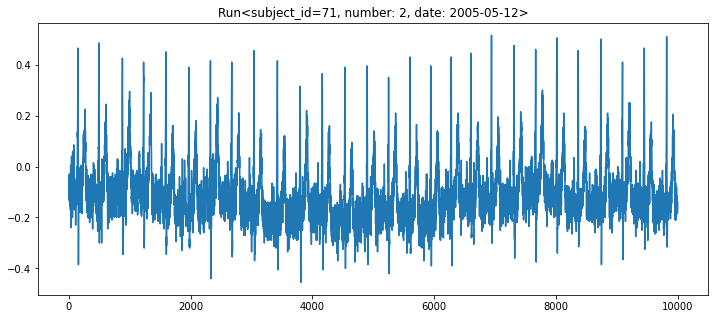

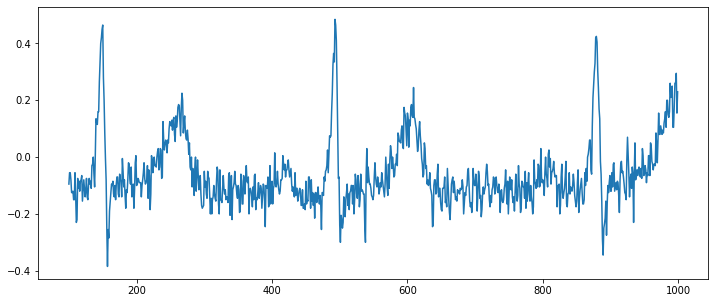

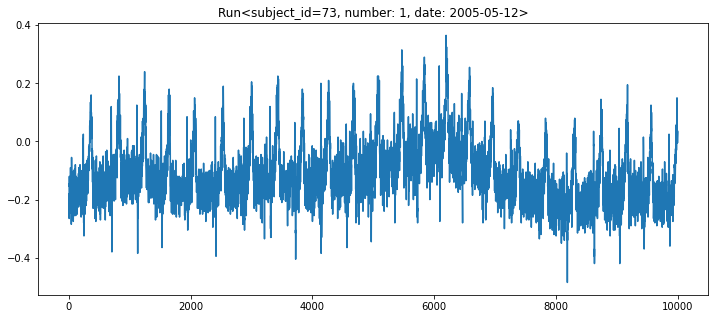

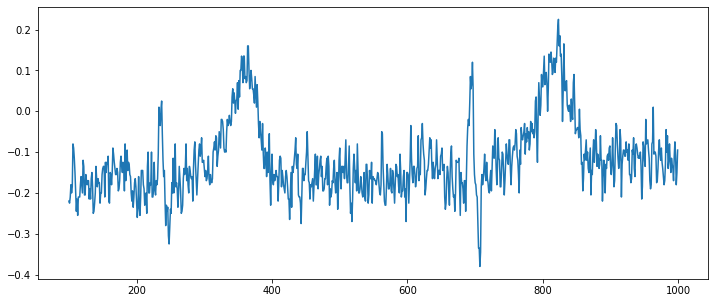

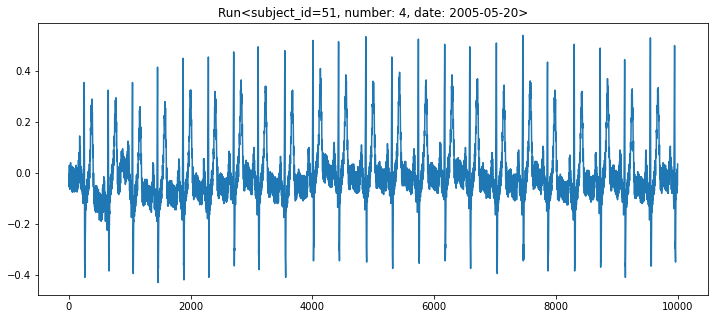

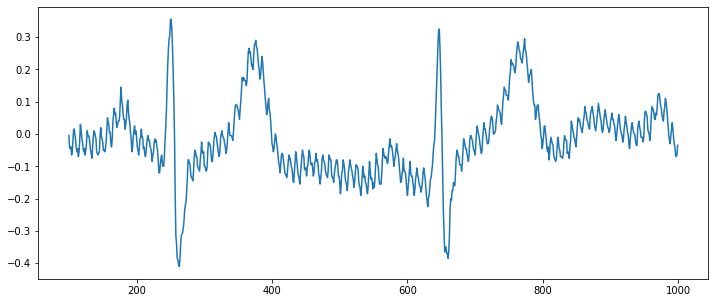

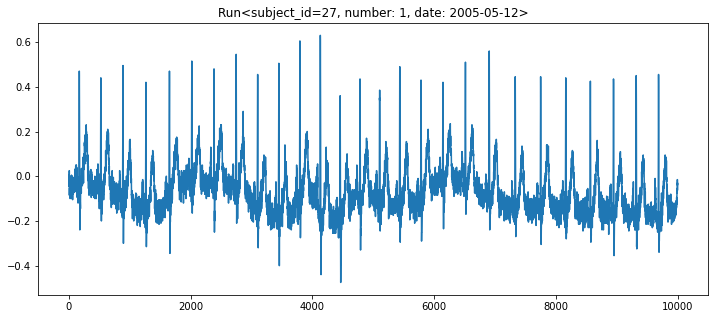

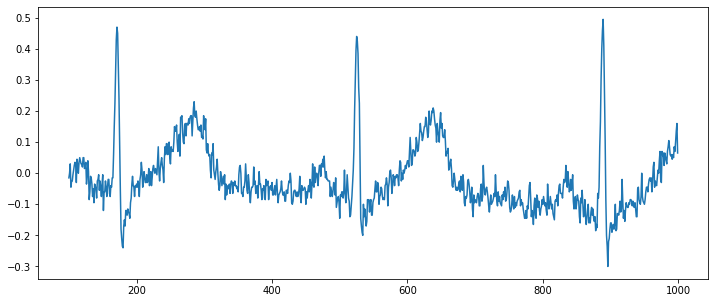

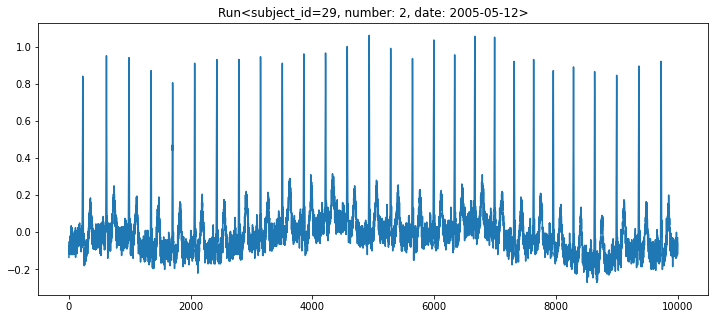

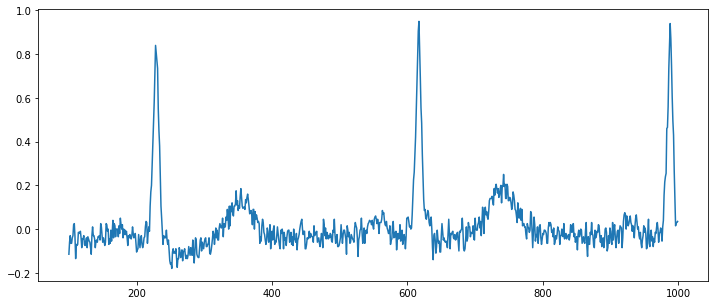

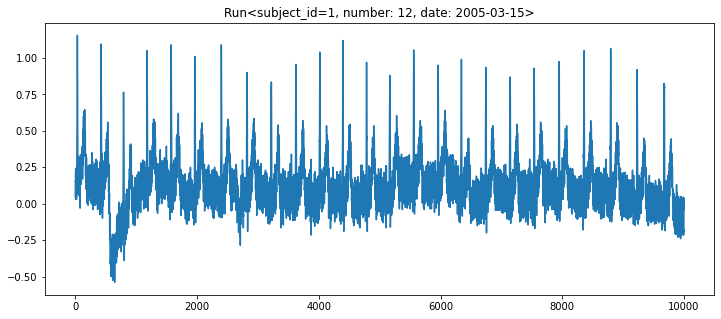

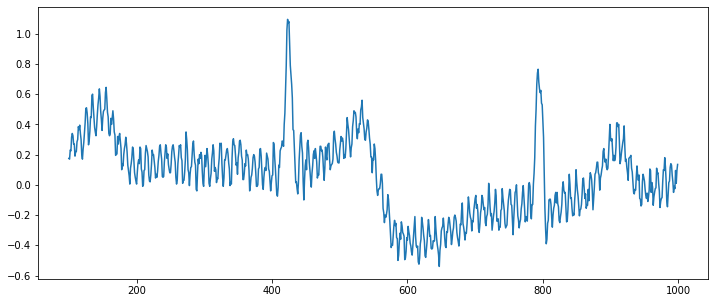

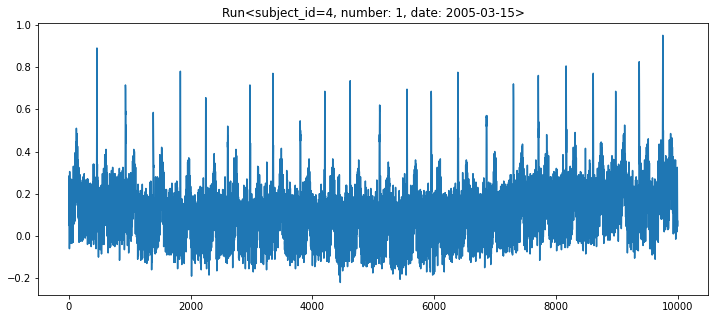

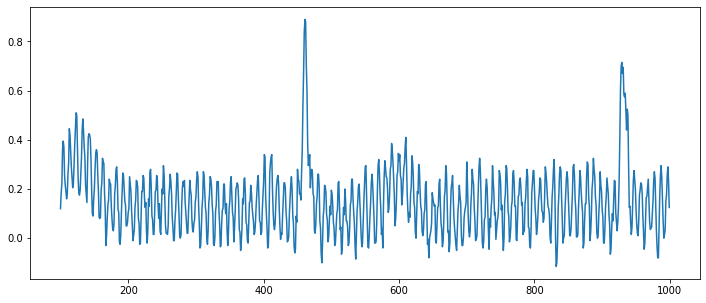

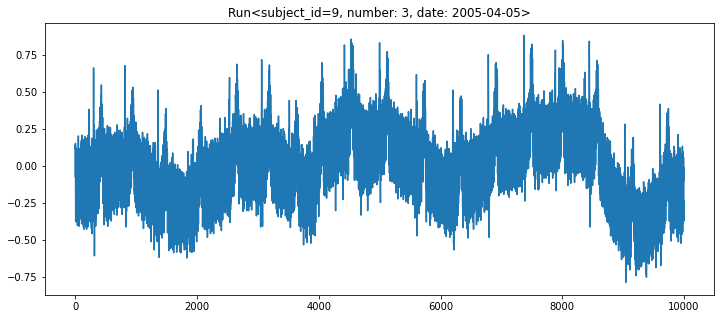

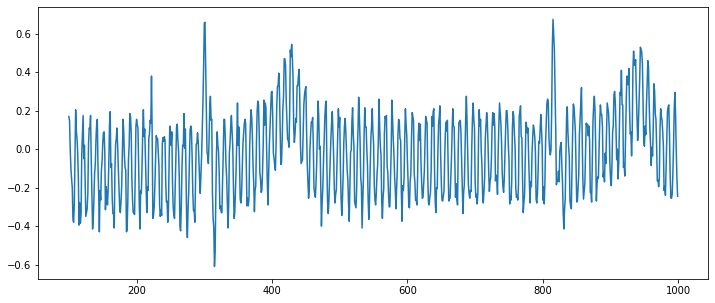

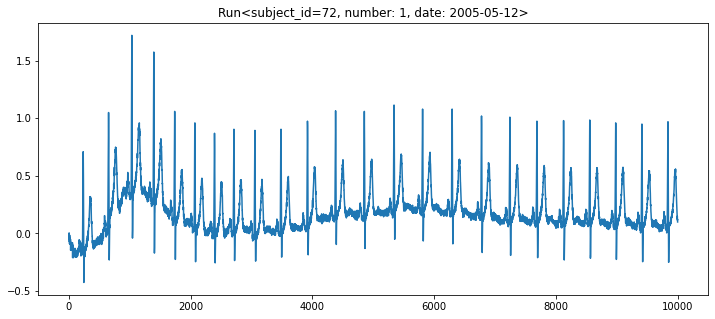

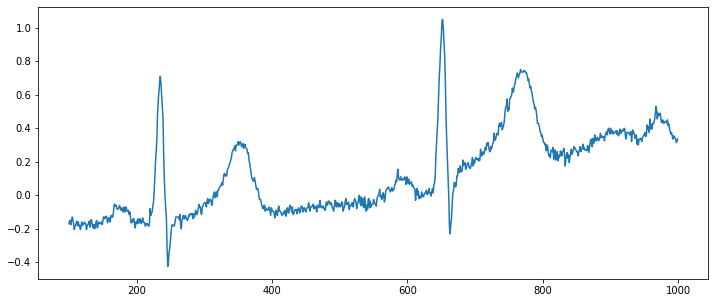

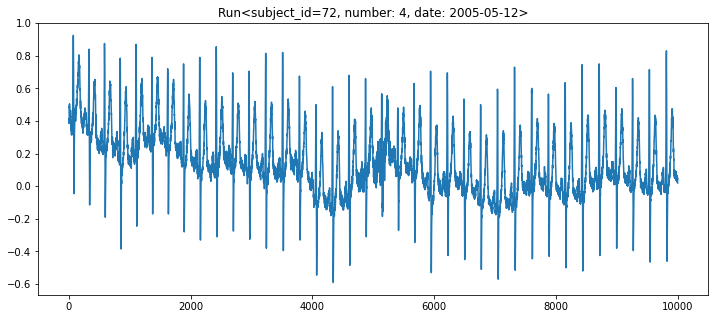

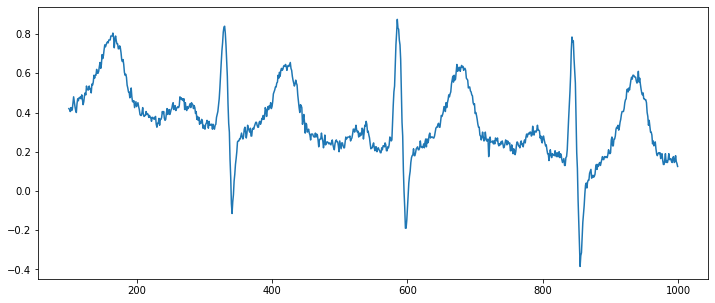

In [4]:
# let's plot
n_runs = 10
random_runs = get_random_runs(session, n=n_runs)

for run in random_runs:

    visualize_run(run)
    
    print("=" * 100)
    

# What jumps out in these plots?

1) **Baseline Wander**: periodicity is clear from the R waves, but the baseline itself has noticeable drift in many of the runs. Ideally, we would like each R wave to have the same horizontal reference point.  
2) **Noise**: The "zoomed in" views show high frequency oscilations around the peaks of interest. My untrained eye can pick out the ST-T "bump", but the jaggedness of the bump is, according to the textbook example, not of much use and would be nice to filter out.  
3) **Zero point**: Some runs are centered around 0, some around -1.0. We may want to rescale these for apples-to-apples comparison.   
4) **Large flats**: Some runs appear to have a few seconds of silence, possibly electrodes coming off.

## 1) Baseline Wander

A package named **HeartPy** has been a good source of documentation on ECG analysis in Python.  
[GitHub](https://github.com/paulvangentcom/heartrate_analysis_python/) ||
[Docs](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/index.html)  

NB: I've carefully gone through the source code and confirmed that all of the important math that HeartPy does is done in scipy, which is great, because while scipy's math is trustworthy due to its long history of public openness, its documentation is not great. Furthermore, helper functions for picking out sane defaults using domain knowledge are awesome.

One recommendation for treating baseline wander, according to this package's author, is using a "notch" filter, ([scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.iirnotch.html) implementation), with a cutoff of ~0.5Hz.   

They demonstrate the effectiveness of the notch filter in [this notebook](https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/5_noisy_ECG/Analysing_Noisy_ECG.ipynb), so we'll take it for a spin too.

In [5]:
from heartpy import filtering as hpf

In [6]:
def filter_and_plot(run: Run, filter_type, cutoff, zoom_in=False, raw=None):
    """
    MODIFIED FROM HeartPy's Documentation for convenience:
    
    run : bodyport database mapping object representing the run

    zoom_in : bool,
        whether to also plot a zoomed_in view of the run

    cutoff : int, float or tuple
        the cutoff frequency of the filter. Expects float for low and high types
        and for bandpass filter expects list or array of format [lower_bound, higher_bound]

    filtertype : str
        The type of filter to use. Available:
        - lowpass : a lowpass butterworth filter
        - highpass : a highpass butterworth filter
        - bandpass : a bandpass butterworth filter
        - notch : a notch filter around specified frequency range
        both the highpass and notch filter are useful for removing baseline wander. The notch
        filter is especially useful for removing baseling wander in ECG signals.
    """
    
    data = raw if raw is not None else run.raw['ecg_raw'].values  # allow passing in data directly if desired
    
    sample_rate = run.fs
    figure_title = run.__repr__()
    
    # zoom in if specified
    values = data[100:1000] if zoom_in else data
    
    # apply filter
    filtered = hpf.filter_signal(values, sample_rate=sample_rate, cutoff=cutoff, filtertype=filter_type)

    # empty canvas
    plt.figure(figsize=(12,5))
    plt.title(figure_title)
    
    # plot original
    pd.Series(values).plot(label='original')
    
    # plot filtered on same canvas
    pd.Series(filtered).plot(label=f"{filter_type} filter - cutoff {cutoff}")

    plt.legend()
    plt.show()
    
    return filtered

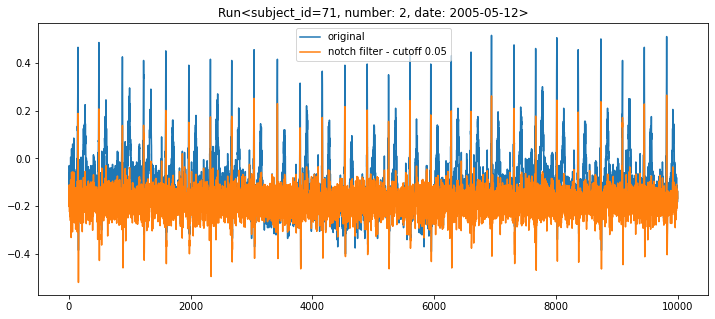

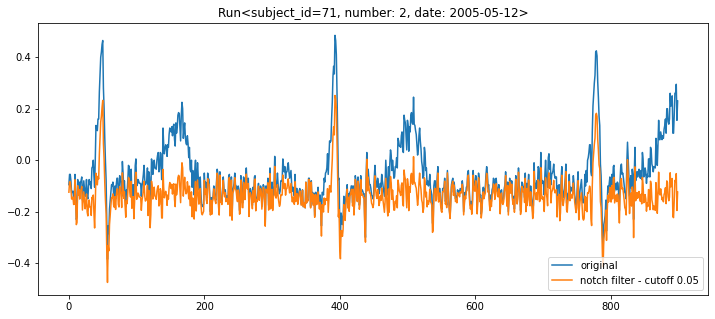

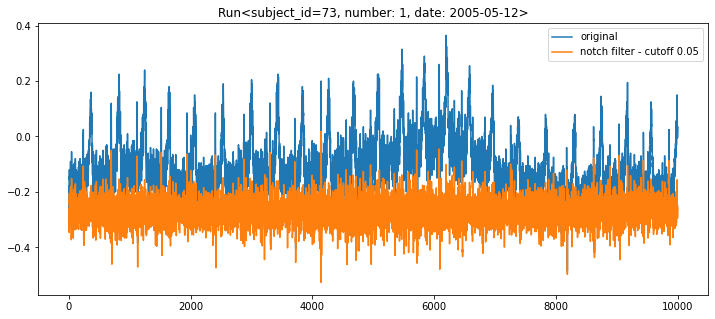

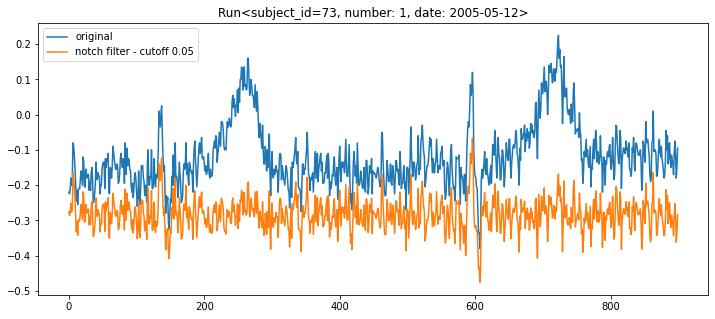

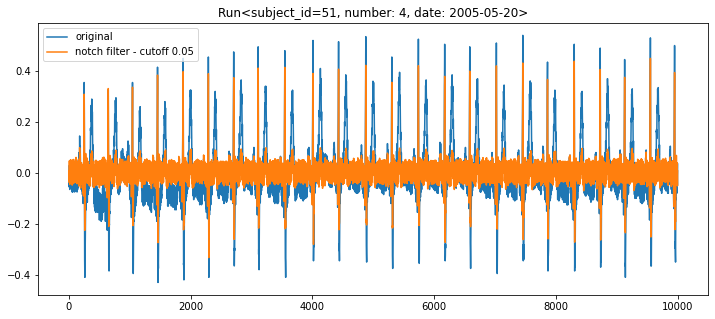

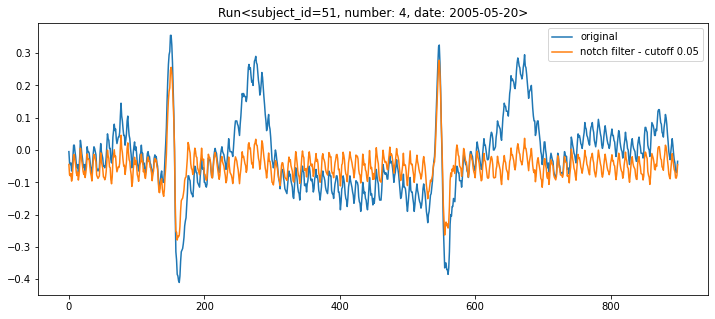

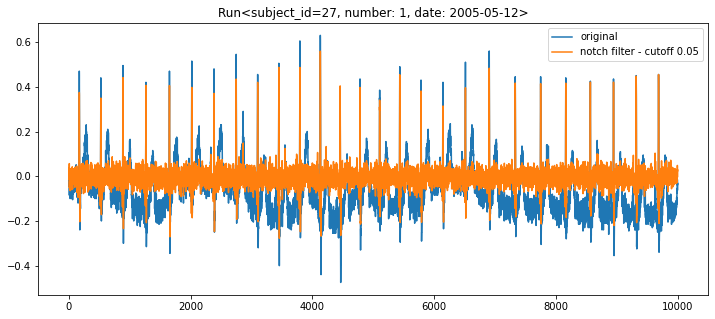

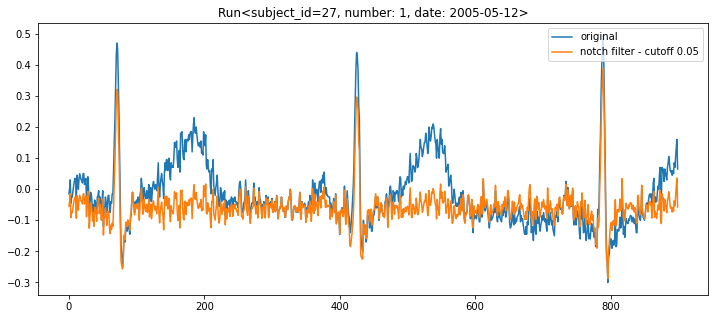

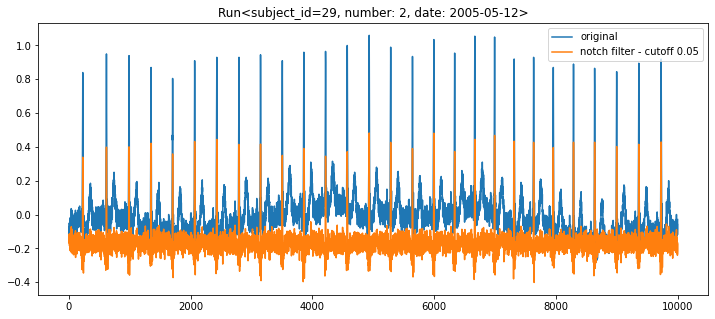

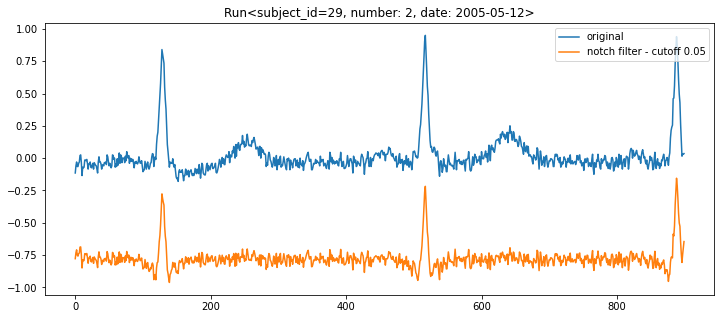

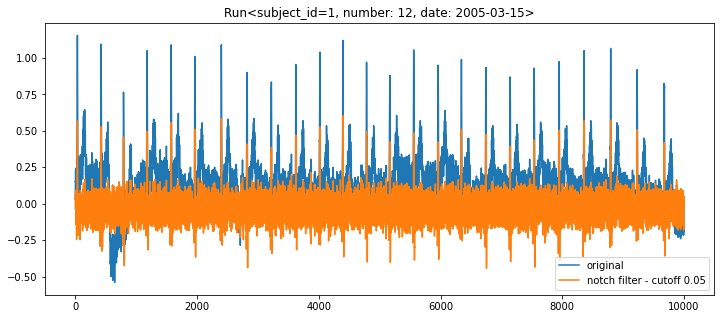

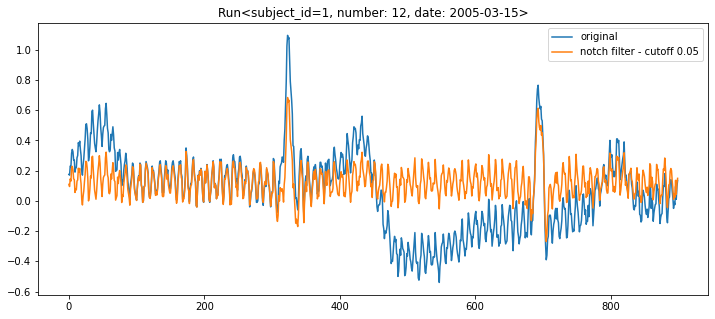

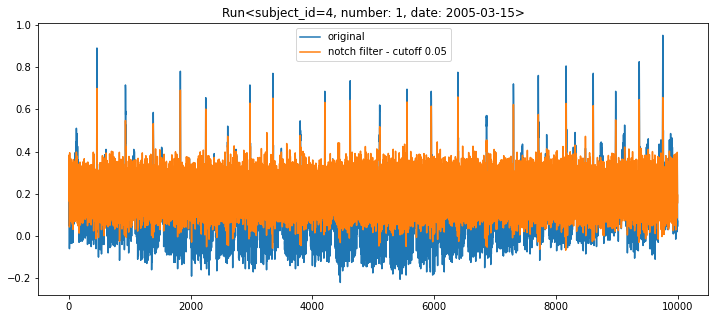

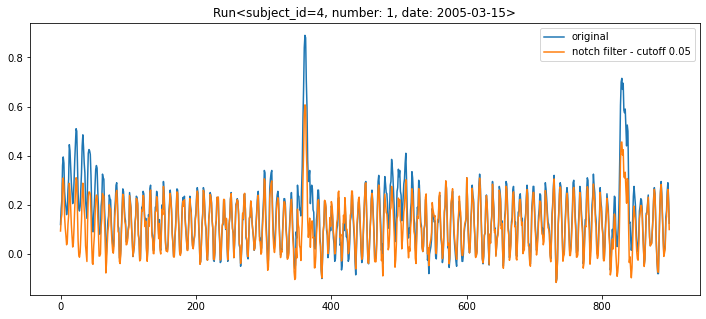

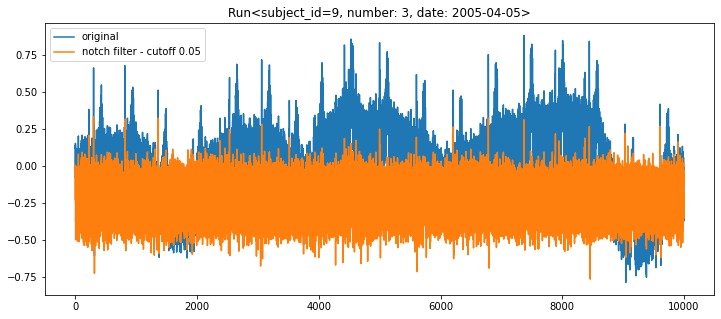

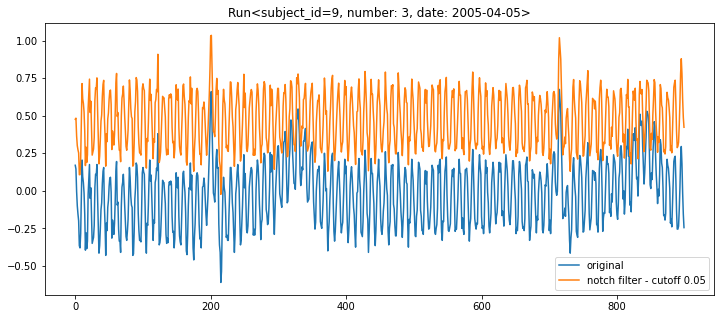

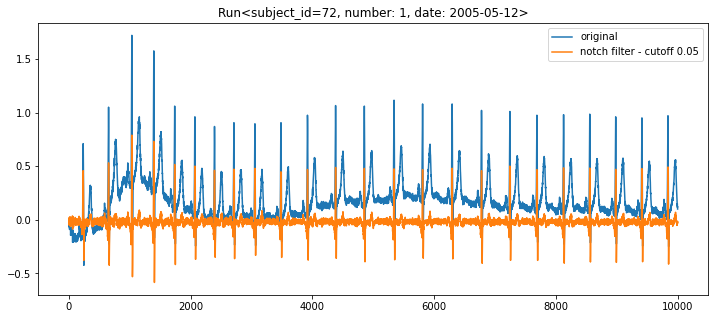

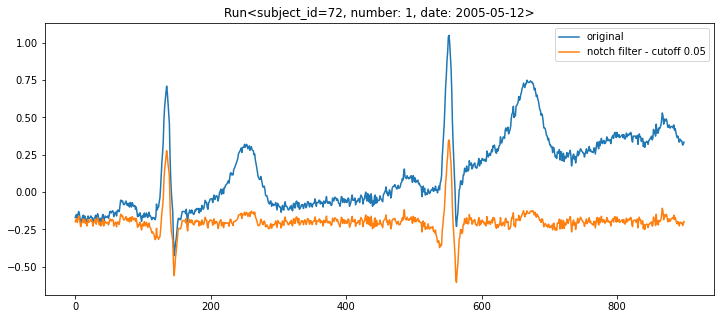

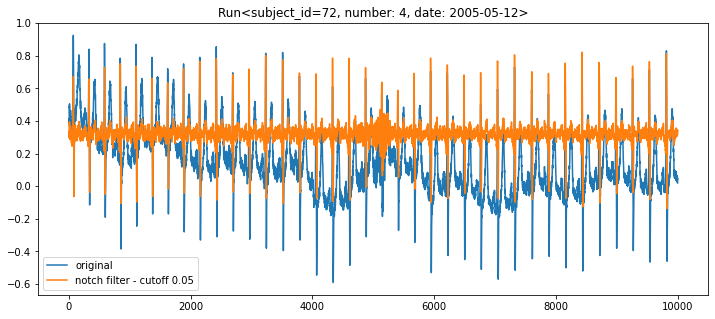

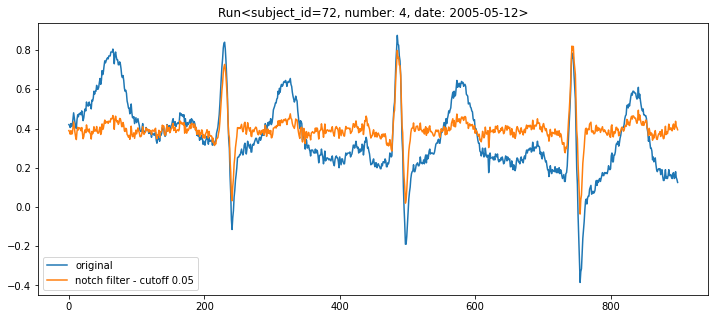

In [7]:
cutoff = 0.05  # recommended by package
for sample_run in random_runs:
    filter_and_plot(sample_run, cutoff=cutoff, filter_type='notch')
    filter_and_plot(sample_run, cutoff=cutoff, filter_type='notch', zoom_in=True)
    print('=' * 100)

Well, that does a pretty good job of de-trending the signal while preserving the temporal position of the peaks. That's pretty good.  

However, it does seem like the ST-T segment is very subdued by the filter, so we may be losing signal.  

Can we adjust the cutoff parameter to make the filter less heavy-handed? The default recommended was 0.05. Let's try something smaller.

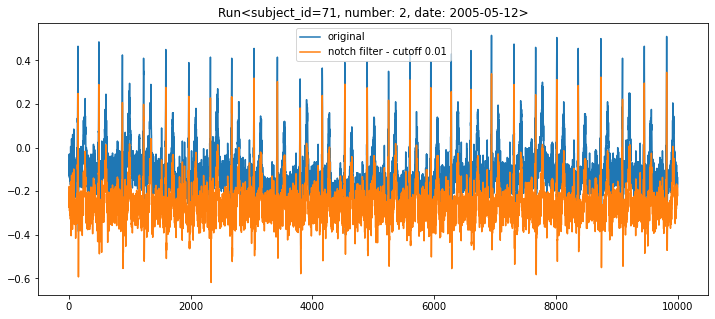

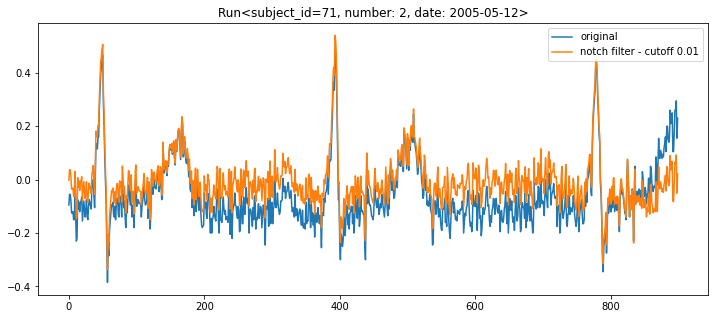

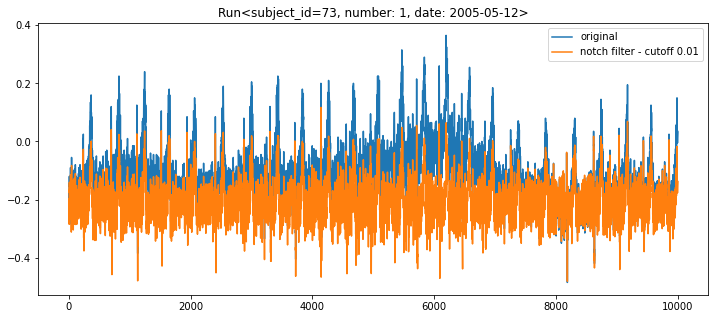

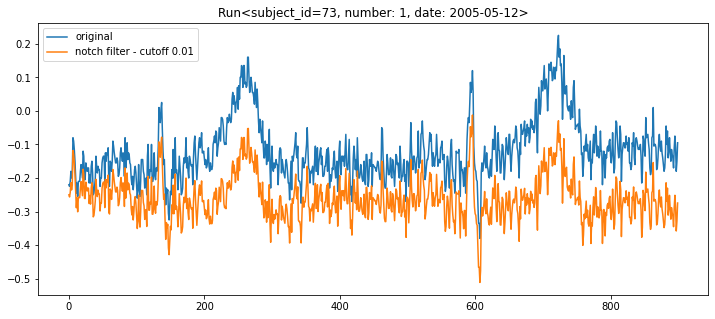

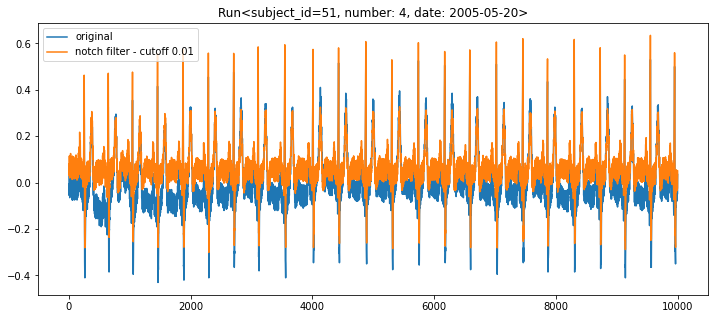

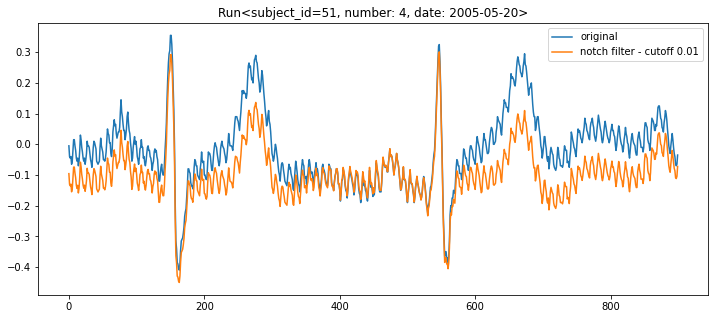

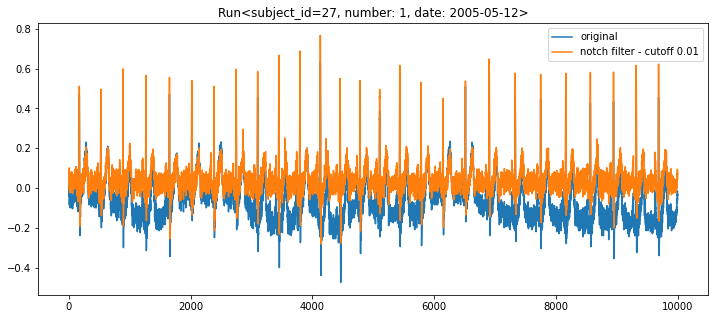

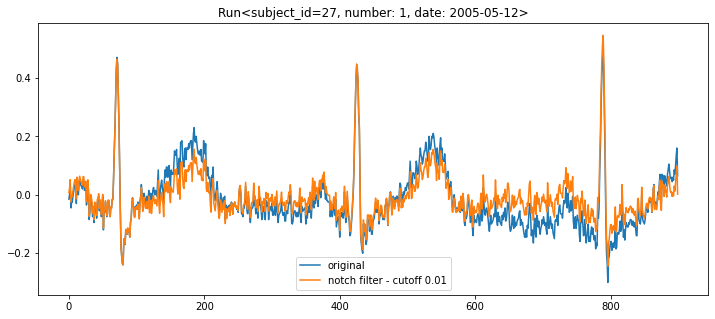

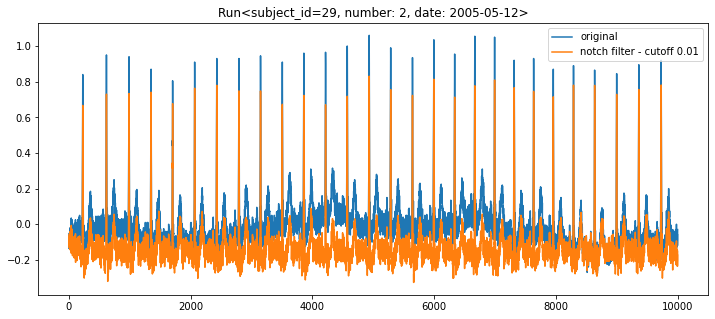

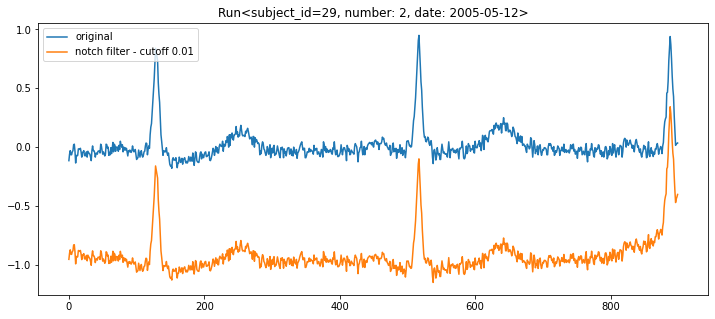

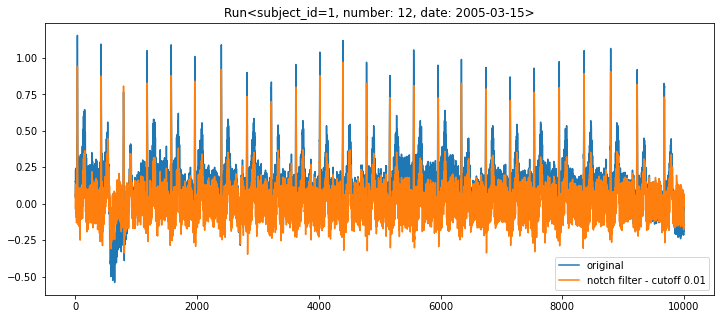

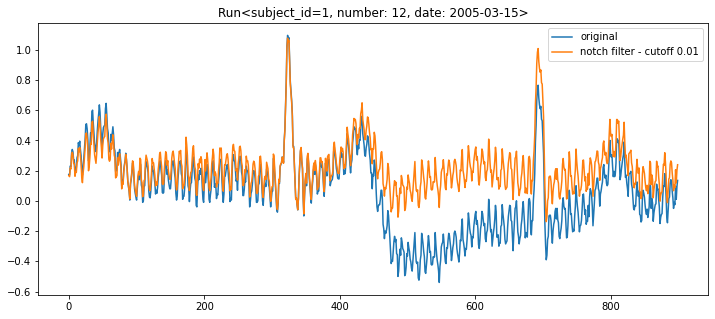

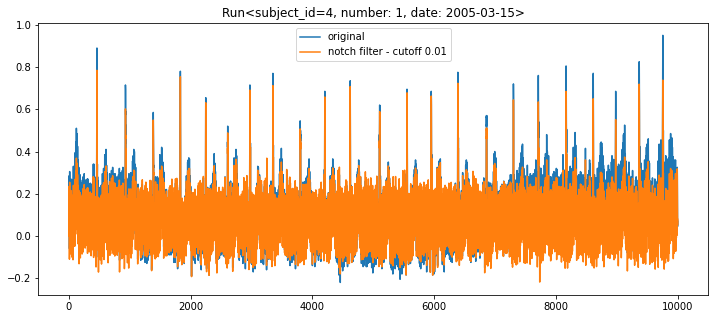

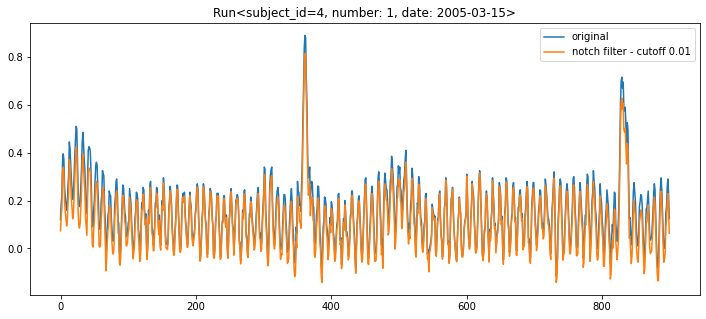

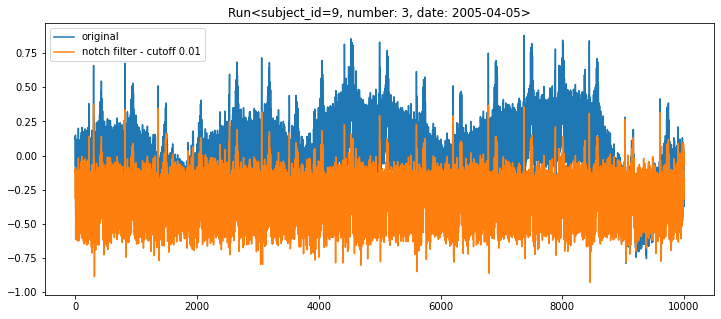

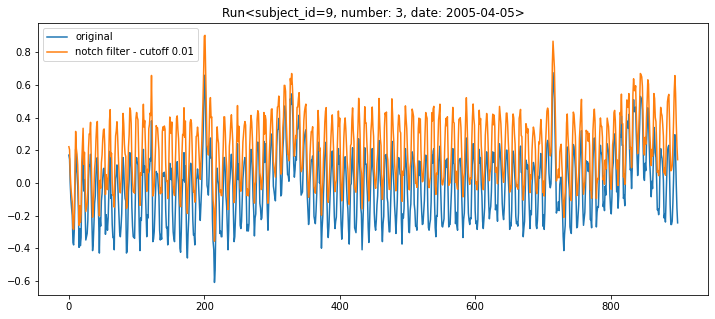

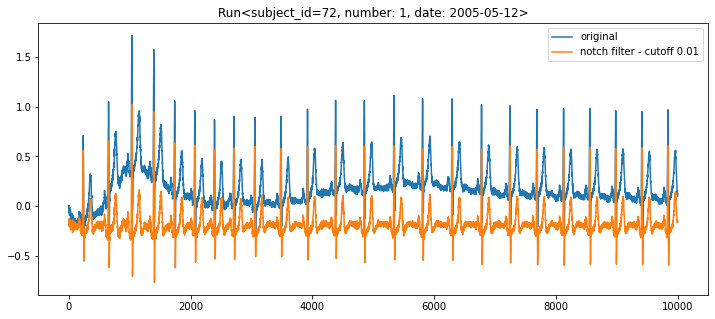

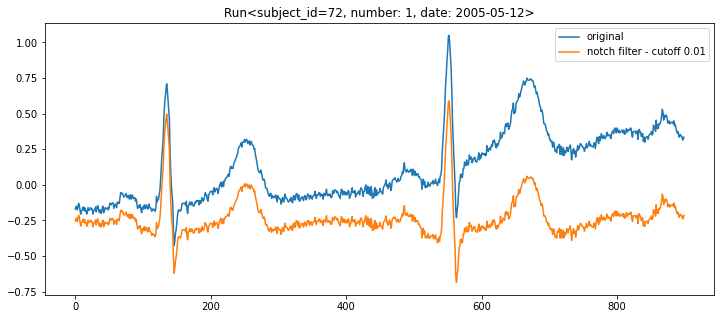

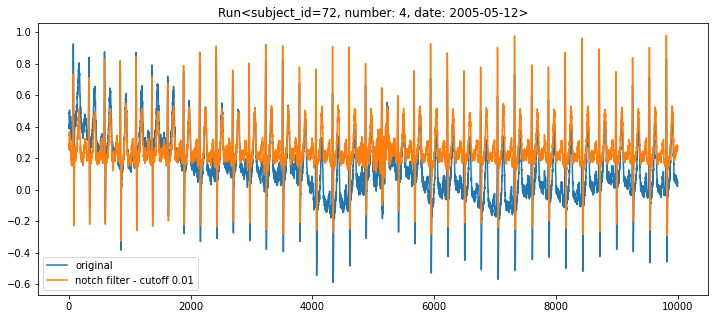

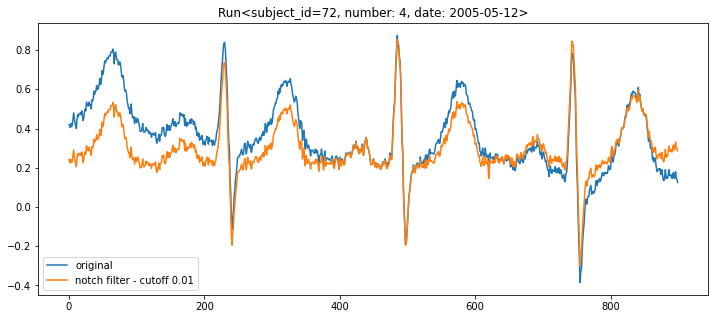

In [8]:
cutoff = 0.01
for sample_run in random_runs:
    # storing the filtered values now in run.based
    sample_run.based = filter_and_plot(sample_run, cutoff=cutoff, filter_type='notch')
    filter_and_plot(sample_run, cutoff=cutoff, filter_type='notch', zoom_in=True)
    print('=' * 100)

Much better! With a cutoff of 0.01, the filtered signal tracks the original much more closely, and the baseline wandering is gone, even in some particularly egregious drifts.

The JBER article linked above also recommends: "Finite Impulse Response (FIR) high-pass zero phase forward-backward filtering with a cut-off frequency of 0.5 Hz"

The "notch" filter implemented above is an IIR (digital) method, not FIR (analog). However, it should perform similarly as it is considered a "common case" (see [Advantages and Disadvantages section](https://en.wikipedia.org/wiki/Infinite_impulse_response#Advantages_and_disadvantages) of the Wikipedia IIR article), and it is both:   
- "high-pass" in that it filters out low frequencies, and  
- "zero phase (via) forward-backward filtering" -- this is what scipy.signal.filtfilt implements. Zero-phase simply means the peaks are not shifted, as a result of a double-pass (forward and backward) which we already see to be true from the result of the notch filter.  

So we're likely on a decent track for fixing baseline drift.

## 2. Smoothing

What other frequencies can we filter out to get a smoother signal? Can we get rid of some jitteriness to see underlying signal?  

According to the article linked in the intro, the 50/60Hz regime is often filled with noise due to ambient electromagnetic radiation. What if we cut off just below, at 40 Hz, on the baseline-drift-adjusted signal? (calling that 'based', accessible in `run.based` property in memory)

https://www.hindawi.com/journals/bmri/2019/2608547/

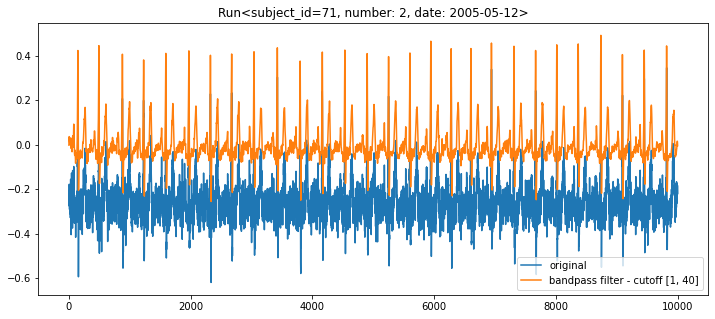

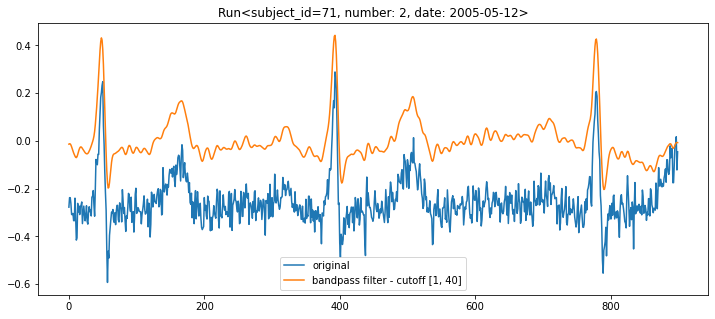

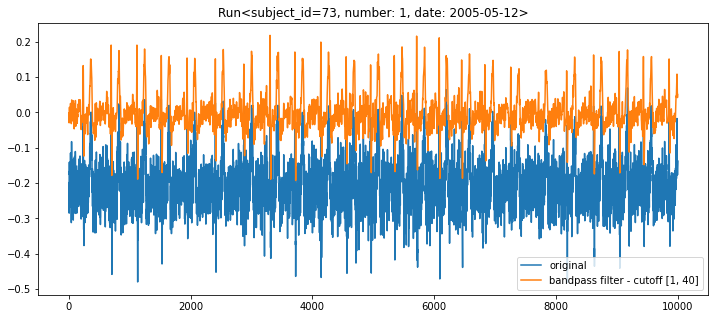

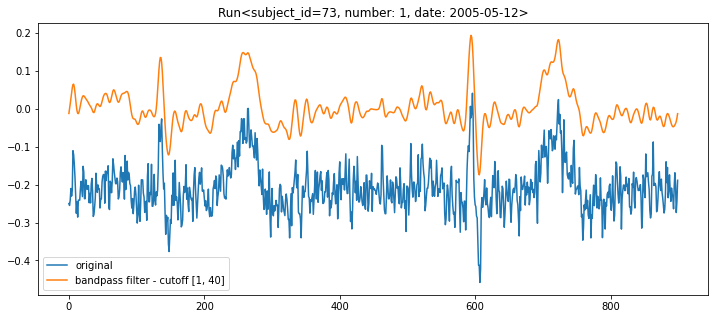

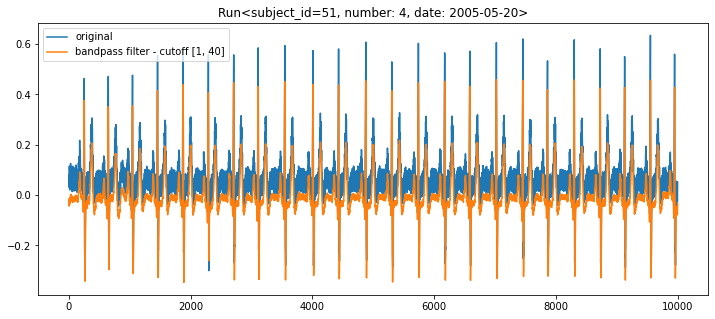

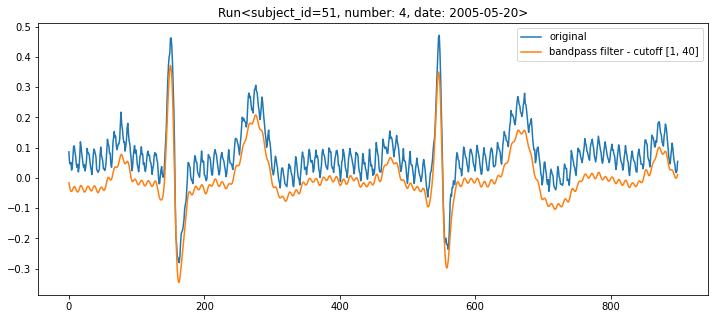

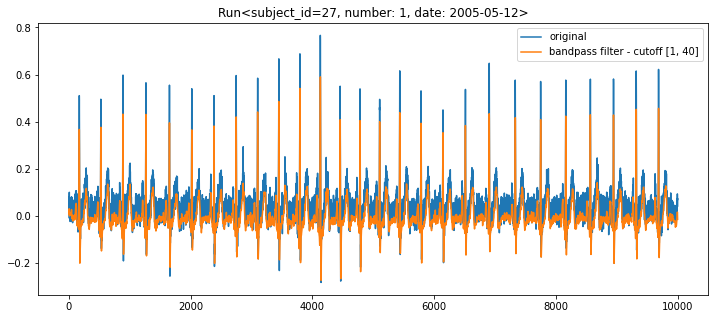

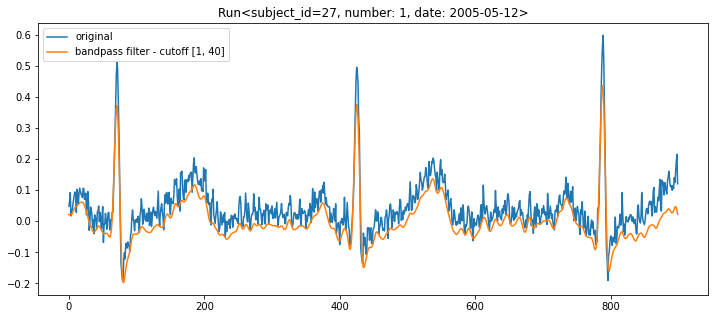

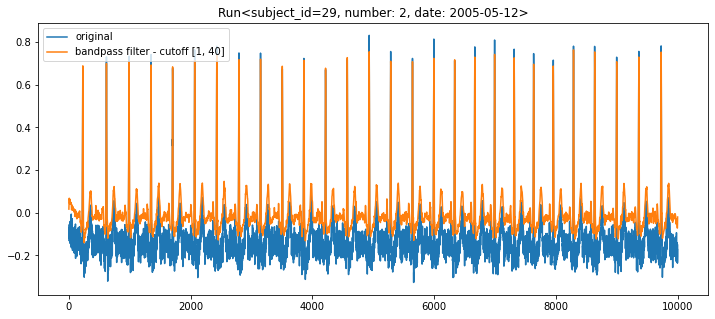

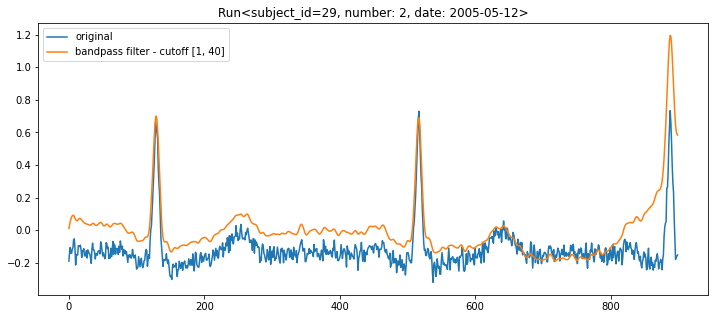

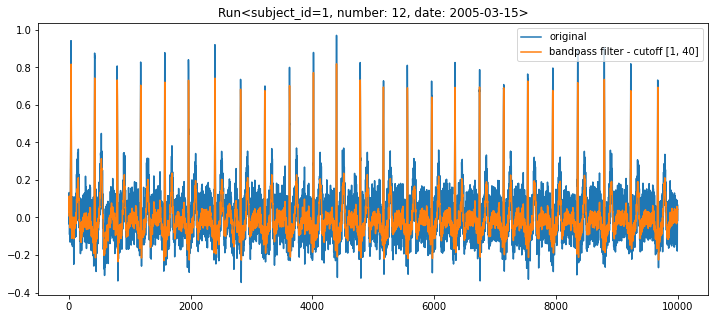

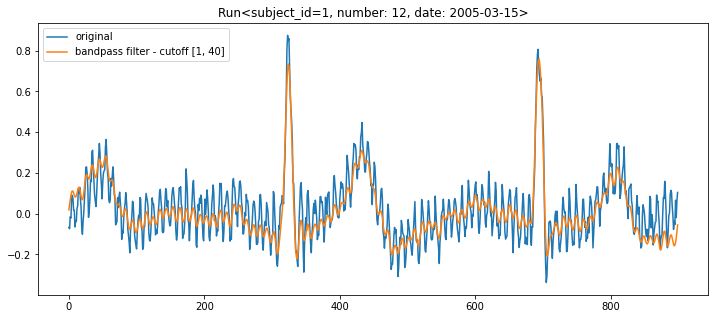

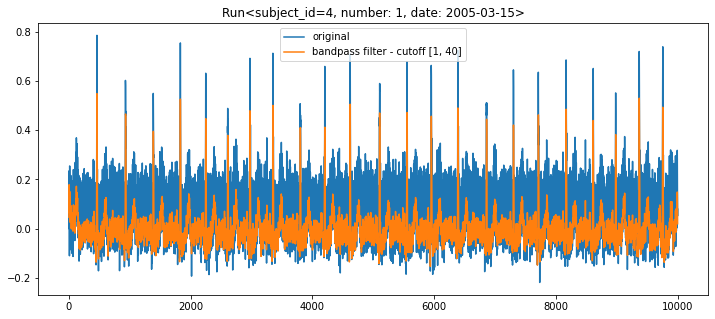

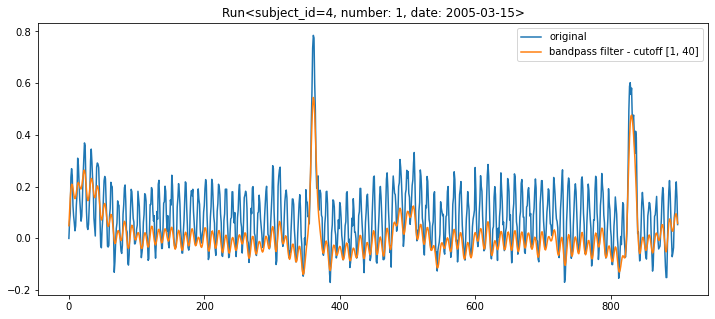

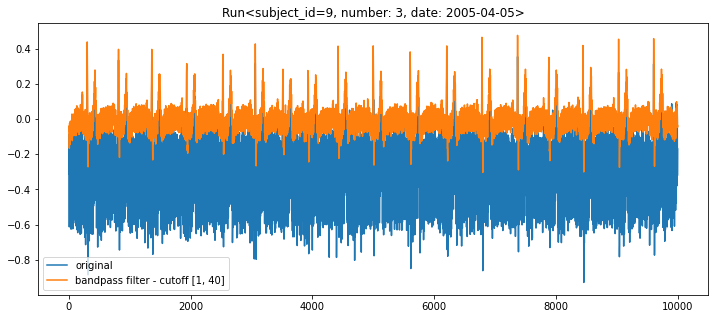

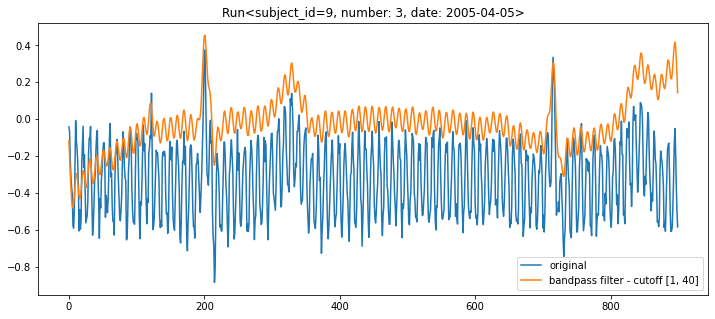

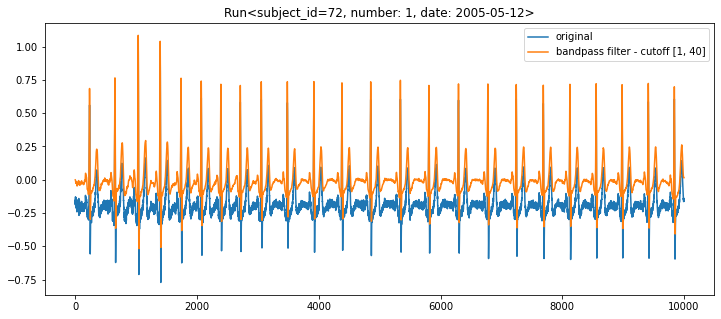

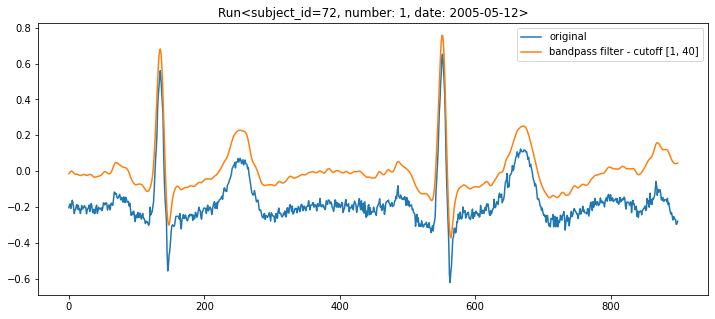

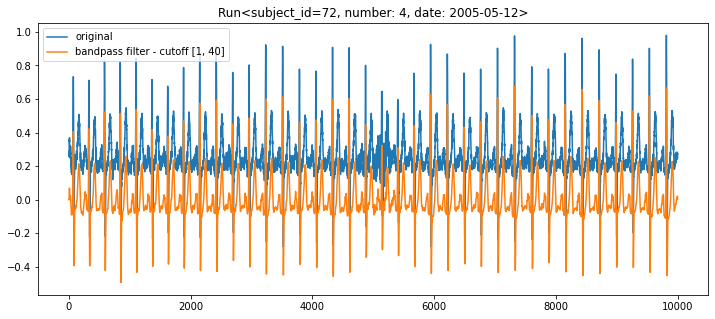

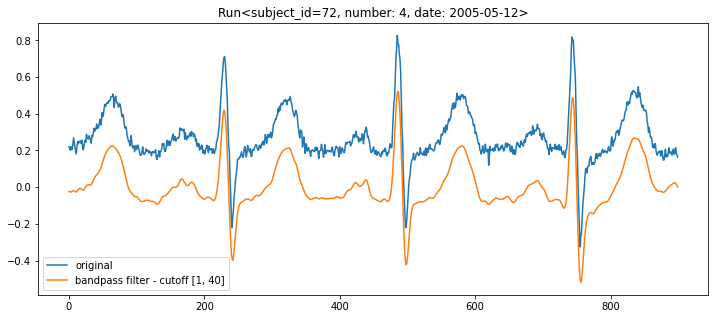

In [9]:
cutoff = [1, 40]  # bandpass, keeping only frequencies between 1 and 40Hz
for sample_run in random_runs:
    #NB: "original" here refers to the baseline-drift-adjusted signal
    filter_and_plot(sample_run, cutoff=cutoff, filter_type='bandpass', raw=sample_run.based)
    filter_and_plot(sample_run, cutoff=cutoff, filter_type='bandpass', raw=sample_run.based, zoom_in=True)

This is a marked improvement. Peaks are still aligned, but the trends are far clearer. I also experimented with pushing the lower end of the bandpass to 5Hz, but that distorts the signal. At 1Hz it seems stable and smooth.  

I'd next experiment with the `savitzky-golay filter`, which seems to be popular for smoothing purposes.  

# Modeling

Assessing similarity of time series is really a question of mapping the data into a space where a meaningful "distance metric" can be established. In the world of NLP, for instance, the embedding space learned by word vectors places similarly co-occurring words closer together in a non-Euclidean space, where something like cosine-distance can then be used to determine semantic closeness.

Thinking about it this way, I would like to find a representation of biometric time series signatures that is fixed-width and compresses the signal into as few variables as possible. We'd want a low re-construction error from a few features that capture both the frequency domain and how the frequency domain shifts over time. 

One way we could test the efficacy of the distance metric would be, for instance, by calculating how much more often k-means would assign the same person's different readings to the same cluster, than would be expected by chance. 

Alternatively, we could treat the individual as a label, and try to predict the individual with a set of engineered features and a supervised classifier like logistic regression or XGboost. I suspect for this method would work only if we had many runs per person, though, as the number of classes would be 80, and most of our subjects have only 1 or 2 runs.

The technique I would investigate next for deriving a low-dimensional representation would be Discrete Wavelet Transform. They seem to have been getting a lot of citations and fit the bill for ECG, because they simultaneously describe the frequency domain and a frequency/time domain in a number of coefficients, which could be the rich representation we are looking for.

[ECG Signal Compression Using DWT](https://www.intechopen.com/books/discrete-wavelet-transforms-theory-and-applications/ecg-signal-compression-using-discrete-wavelet-transform)

# Appendix: Feature Engineering

Can we get heartbeat?  HeartPy claims to have an implementation, let's test it:

In [10]:
sample_run

Run<subject_id=72, number: 4, date: 2005-05-12>

In [11]:
sample_data = sample_run.raw.ecg_raw.values

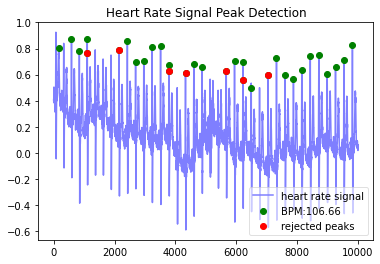

In [12]:
import heartpy as hp

working_data, measures = hp.process(sample_data, sample_run.fs)

hp.plotter(working_data, measures)

In [13]:
measures['bpm']

106.6616766467066

### An average bpm of 152 seems extremely high.

Let's vet HeartPy a bit more thoroughly by trying all other runs and checking the distribution. 

We will check HeartPy's output against another open-source package, [BioSppy](https://biosppy.readthedocs.io/en/stable/biosppy.signals.html#biosppy.signals.ecg.ecg). Once again largely wrapped around scipy, it implements algorithms from a vast number of papers for processing ECG signals.


(I also want to point out the power of the Run class, in that we can very quickly add columns to the data warehouse to store complex features related to any run or subject, resulting in rapid development of feature libraries and deployment of best practices as the team discovers them.)

In [14]:
# quick demo ov biosppy capability

from biosppy.signals.ecg import ecg

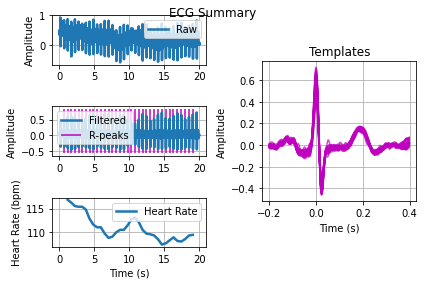

In [15]:
ecg_out = ecg(signal=sample_data, sampling_rate=sample_run.fs)

# unpacking the output:
ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg_out

In [16]:
# biosppy measured average heartrate:
heart_rate.mean()

110.88207017940402

The bpm from Biosppy is much more reasonable for a person at rest.   

Also, the second plot on the left ("filtered") appears like an automatically baseline-adjusted read, which HeartPy required some tuning to get right.

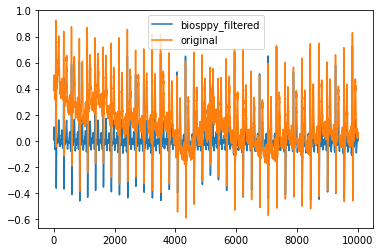

In [17]:
# zooming in on biosppy's "filtered"

pd.Series(filtered).plot(label='biosppy_filtered')
pd.Series(sample_data).plot(label='original')

plt.legend()

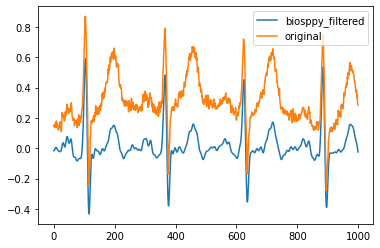

In [18]:
pd.Series(filtered[1000:2000]).plot(label='biosppy_filtered')
pd.Series(sample_data[1000:2000]).plot(label='original')

plt.legend()

Maybe we just got lucky with this run, but this seems promising. We'll save all the biosppy filtered features as we loop through all runs

In [19]:
all_runs = session.query(Run).all()

for i, run in enumerate(all_runs):
    signal = run.raw['ecg_raw'].values
    
    # get Biosppy measures
    ecg_out = ecg(signal=signal, sampling_rate=run.fs, show=False)
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg_out

    run.biosppy_heart_rate = heart_rate
    run.biosppy_filtered = filtered
    run.biosppy_rpeaks = rpeaks
    
    # get heartpy measures (less robust to errors, so try/except)
    try:
        _, hpy_measures = hp.process(signal, run.fs)
        run.hpy_avg_bpm = hpy_measures['bpm']
    except:
        run.hpy_avg_bpm = None

/Users/sep/.pyenv/versions/3.8.2/envs/bodyport/lib/python3.8/site-packages/numpy/ma/core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/Users/sep/.pyenv/versions/3.8.2/envs/bodyport/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sep/.pyenv/versions/3.8.2/envs/bodyport/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sep/.pyenv/versions/3.8.2/envs/bodyport/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sep/.pyenv/versions/3.8.2/envs/bodyport/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by t

Great, let's look at HeartPy's pulse on our subjects: how is the average bpm as measured by HeartPy distributed?

In [20]:
hpy_avg_bpms = pd.Series([run.hpy_avg_bpm for run in all_runs])

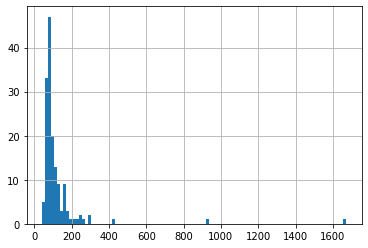

In [21]:
hpy_avg_bpms.hist(bins=100)

Definitely some outliers here. Perhaps a few particularly excited hummingbirds made it to the ECG table as well. 

Zooming in on those with less than 200 BPM:

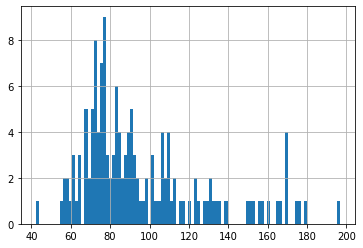

In [22]:
hpy_avg_bpms[hpy_avg_bpms < 200].hist(bins=100)

Still far too many outside of the 120BPM range

In [23]:
# biospy gives us several BPM readings per run. We'll take the average, and display that.

bio_avg_bpms = pd.Series([run.biosppy_heart_rate.mean() for run in all_runs])

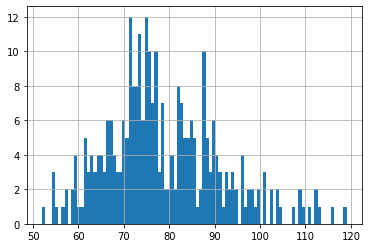

In [24]:
bio_avg_bpms.hist(bins=int(len(all_runs) * 0.33))

### BioSppy's heart beat measurements appear vastly superior to HeartPy's

Let's save it to the Data Warehouse as a new feature.

In [25]:
for run in session.query(Run).all():

    signal = run.raw['ecg_raw'].values
    
    # get Biosppy measures
    ecg_out = ecg(signal=signal, sampling_rate=run.fs, show=False)
    
    # unpack output
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg_out

    run.avg_bpm = heart_rate.mean()

# save to data warehouse
session.commit()

In [26]:
# test that it worked:
session.query(Run).first().avg_bpm

87.49508048175831

Great, now we can track BPMs over time for a subject, check distribution of BPMs over gender and age, etc. etc.

# Statistical summary of all runs

## 1. Outliers -- what are the mins and maxes of amplitudes in the whole dataset?

In [27]:
# we have 290 runs
session.query(Run).count()

290

Let's concatenate all the runs into a single dataframe so we can get statistical summaries of all:

In [28]:
dfs = []
for run in session.query(Run).all():
    df = run.raw
    df['subject_id'] = run.subject_id
    df['run_number'] = run.number
    df['run_id'] = f"{run.subject_id}_{run.number}"
    df['ts_index'] = df.index
    dfs.append(df)

master = pd.concat(dfs)

master.head()

ecg_raw  subject_id  run_number run_id  ts_index
0    -0.27          12           1   12_1         0
1    -0.23          12           1   12_1         1
2    -0.16          12           1   12_1         2
3    -0.15          12           1   12_1         3
4    -0.06          12           1   12_1         4

In [29]:
# we have some 2.9 million rows altogether
master.shape

(2900000, 5)

In [30]:
# group by run
run_group = master.groupby(['run_id'])['ecg_raw']

run_group.size().value_counts()

10000    290
Name: ecg_raw, dtype: int64

Looks like each of the 290 runs is 10000 lines. At 500Hz, this corresponds to **20 seconds** of recording.

# distribution of amplitudes per run

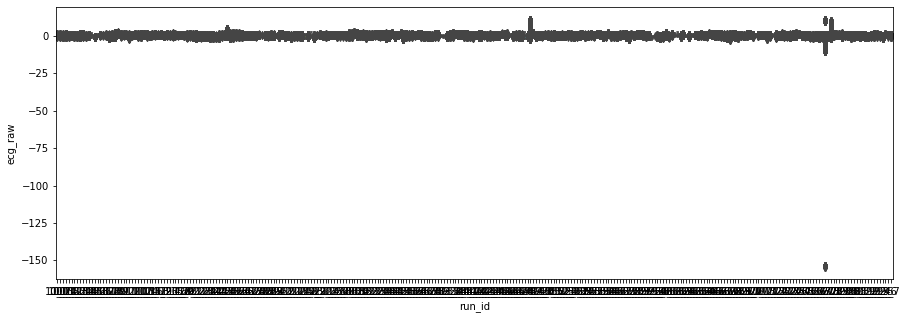

In [31]:
# box plot of each run to quickly find anomalies
plt.figure(figsize=(15, 5))
sns.boxplot(x='run_id', y='ecg_raw', data=master)

Out of curiosity: let's figure out which Run is way out of line on the bottom right

In [32]:
# min per run
run_mins = run_group.min()

# find run with global minimum amplitude
run_mins[run_mins == run_mins.min()]

run_id
76_2   -154.155
Name: ecg_raw, dtype: float64

**Subject 72, run 2** is the outlier

In [33]:
master[master['run_id'] == '76_2']['ecg_raw'].describe()

count    10000.000000
mean       -14.999309
std         45.963141
min       -154.155000
25%         -0.055000
50%          0.015000
75%          0.100000
max         10.745000
Name: ecg_raw, dtype: float64

This same run also has a very high max, so it's not just a maladjusted baseline that is the issue -- it appears to be suffering from some high-magnitude noise. Let's see if there are any others with similarly high standard deviations

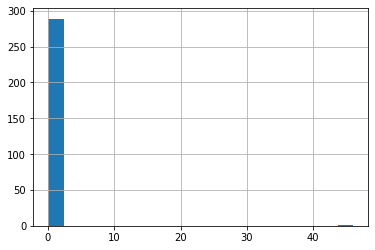

In [34]:
run_stds = run_group.std()

# distribution of standard deviations
run_stds.hist(bins=20)

In [35]:
# standard deviations are all pretty close to 1 already.
run_stds[run_stds > 2].sort_values()

run_id
47_2     2.351460
76_2    45.963141
Name: ecg_raw, dtype: float64

It's pretty much just run 76_2 that has a huge standard dev (46). The second largest is 2.4, and the rest are much closer to 0. 

Since the problem doesn't seem to affect a lot of runs, I'll focus more on the more prevalent issues of 
1. denoising / filtering high and low frequencies
2. smoothing, and
3. removing baseline wandering

solving which may very well ameliorate this problem as well.

# Number of runs per subject:

In [36]:
runs_per_subject = pd.read_sql("""
    select 
        subject_id,
        count(distinct number) as n_runs 
    from run 
    group by 1
""", con=session.bind)

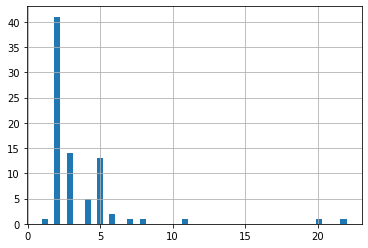

In [37]:
runs_per_subject.n_runs.hist(bins=50)

In [38]:
runs_per_subject.n_runs.value_counts().sort_index()

1      1
2     41
3     14
4      5
5     13
6      2
7      1
8      1
11     1
20     1
22     1
Name: n_runs, dtype: int64

i.e.   
1 subject has 1 run  
41 subjects have 2 runs  
14 subjects have 3 runs  
4 subjects have 5 runs  
.  
.  
.  

The implication for supervised learning with subject as target is that there likely are not enough runs per person to produce a good model.